In [1]:
import glob
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from utils.data_processing import delay_tensors

In [2]:
def delay_unconstrained_df(group, schema, delay):
    # assert group is sorted by T
    assert torch.all(torch.tensor(group['T'].diff().to_numpy()[1:] >= 0))   # First diff is NaN

    # Get all X1, X2,... columns
    X_cols = [col for col in group.columns if col.startswith('X')]
    df_tensor = torch.tensor(group[X_cols].values)

    group['schema'] = schema
    group['delay'] = delay

    dts, time_constraints, in_schema = delay_tensors(df_tensor, schema, delay)
    
    group['T'] = torch.cumsum(dts, dim=0).numpy()
    group['time_constraints'] = time_constraints
    group['in_schema'] = in_schema.numpy()

    return group

def plot_unconstrained_results(problems, dimensions, algorithms,
                               separate_plots=True, with_selected_delay=None, truncated=True,
                               save=None):
    combinations = list(itertools.product(problems, dimensions))

    # Define a palette and transparency for plotting
    palette_pairs = sns.color_palette('Paired', n_colors=2*len(algorithms))
    palette = {algo: (palette_pairs[2*i],palette_pairs[2*i+1]) for i, algo in enumerate(algorithms)}

    # Create subplots if needed
    if not separate_plots:
        fig, axes = plt.subplots(len(problems), len(dimensions), figsize=(12, 4*len(problems)), sharex=False, sharey=False)
        if len(problems) * len(dimensions) == 1:
            axes = np.array([axes])  # Convert to an array and wrap the single axis in a list

        # Share x-axis for each column
        for col in range(len(dimensions)):
            for row in range(1, len(problems)):  # Start from the second row to link it to the first
                axes[row, col].sharex(axes[0, col])

            # Remove ticks and labels for all but the last row
            for row in range(len(problems) - 1):
                axes[row, col].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

        axes = axes.flatten()  # Flatten to easily index in the loop

    # Loop over combinations of problems and dimensions
    for idx, (problem, dim) in enumerate(combinations):
        # Use glob to find all files matching the pattern for each algorithm
        unconstrained_files_pattern = f'./processed_data/{problem}_{dim}_*_None_None.csv'
        file_paths = glob.glob(unconstrained_files_pattern)

        # Load and concatenate unconstrained files
        df_list_uc = [pd.read_csv(file_path, dtype={'schema': str}) for file_path in file_paths]
        df = pd.concat(df_list_uc, ignore_index=True)

        if with_selected_delay:
            selected_delay_files_pattern = f'./processed_data/{problem}_{dim}_*{with_selected_delay}.csv'
            constrained_files_pattern = glob.glob(selected_delay_files_pattern)
            df_list_c = [pd.read_csv(file_path, dtype={'schema': str}) for file_path in constrained_files_pattern]
            df_c = pd.concat(df_list_c, ignore_index=True)

            # get unique schema from df_c
            df_delay_list = []
            for schema in df_c['schema'].dropna().unique():
                # print(df.groupby(['algo','seed']).apply(lambda group: delay_unconstrained_df(group, schema, with_selected_delay), include_groups=False).index)
                df_delay_list.append(
                    df.groupby(['algo','seed']).apply(lambda group: delay_unconstrained_df(group, schema, with_selected_delay), include_groups=False).droplevel(-1).reset_index()
                )
            df_delay = pd.concat(df_delay_list, ignore_index=True)
            df_delay['algo_kwargs'] = df_delay.apply(
                lambda row: f"{row['algo']}_delayed-{str(row['schema'])[:2]}-sticky{row['delay']}", axis=1
            )

            # Group the dfframe by 'function' and 'algo_kwargs' and get the maximum index across all seeds
            max_indexes = df_delay.groupby(['algo_kwargs'])['T'].max()

            df_fill_list = []
            # Group the dfframe by 'function', 'algo_kwargs', and 'seed'
            for (algo, seed), group in df_delay.groupby(['algo_kwargs', 'seed']):
                # Get the maximum index for this function and algo
                max_index = max_indexes.loc[algo]

                with pd.option_context("future.no_silent_downcasting", True):
                    # Reindex the dfframe to the maximum index and forward fill the missing values
                    group_fill = group.set_index('T').reindex(range(max_index + 1)).ffill().reset_index()

                df_fill_list.append(group_fill)

            # Concatenate all the dfframes in the list into a single dfframe
            df_fill = pd.concat(df_fill_list, ignore_index=True)

            if truncated:
                T_unconstrained = df['T'].max()
                df_fill = df_fill[(df_fill['T'] >= 1) & (df_fill['T'] <= T_unconstrained)]

            # concat unconstrained, constrained and delayed
            df = pd.concat([
                df,
                df_c,
                df_fill
            ], ignore_index=True)


        # Select the axis for plotting (for subplots) or create a new figure (for separate plots)
        if separate_plots:
            plt.figure(figsize=(10, 6))
            ax = plt.gca()  # Get current axis for separate plots
        else:
            ax = axes[idx]  # Target the correct subplot axis

        df['n_off'] = df['schema'].apply(
            lambda x: sum(c.isdigit() for c in str(x)) if not pd.isna(x) else 0
        )
        df['n-off bits'] = df['schema'].apply(
            lambda x: f"{sum(c.isdigit() for c in str(x))} off bits" if not pd.isna(x) else 'unconstrained'
        )

        g = sns.lineplot(
            data=df.sort_values(["algo", "n_off"]),
            x='T',
            y='min_Y',
            hue='algo_kwargs',
            style='n-off bits',
            errorbar=('ci', 95),  # Show the 95% confidence interval
            palette={
                key: palette[key.split('_')[0]][1 if 'constrained' in key else 0]
                for key in df['algo_kwargs'].unique() # Use the first color in the pair if unconstrained, second if constrained
            },
            ax=ax,    # Plot on the right axis
        )
        
        sns.move_legend(g, "upper right", title='Algorithm')

        # Set titles and legends
        ax.set_title(f"{problem.capitalize()} {dim}D")
        ax.set_ylabel('Best observed value')
        ax.grid(False)

        # Remove the legend for all subplots except the last one
        if not separate_plots and idx != len(combinations) - 1:
            ax.get_legend().remove()  # Remove legend for all but the last subplot
        else:
            # Get current handles and labels
            handles, labels = ax.get_legend_handles_labels()
            
            # Filter out handles and labels where the label contains 'a', 'b', or 'c', but is not exactly 'a', 'b', or 'c'
            filtered_handles = []
            filtered_labels = []
            
            for handle, label in zip(handles[1:], labels[1:]):
                if not any(a in label for a in df['algo'].unique()) or label in df['algo'].unique():
                    filtered_handles.append(handle)
                    filtered_labels.append(label)

            ax.legend(title='Algorithm', loc='upper left', handles=filtered_handles, labels=filtered_labels, bbox_to_anchor=(1., 1.),)

    if save is not None:
        plt.savefig(save, bbox_inches='tight', pad_inches=0.1)

In [3]:
# Define the possible values for each parameter
probs = [
    'ackley',
    'michalewicz',
    'levy',
    'styblinskitang'
]
dims = [
    2,
    8
]
algos = [
    'cmaes',
    'sobol',
    'ei'
]

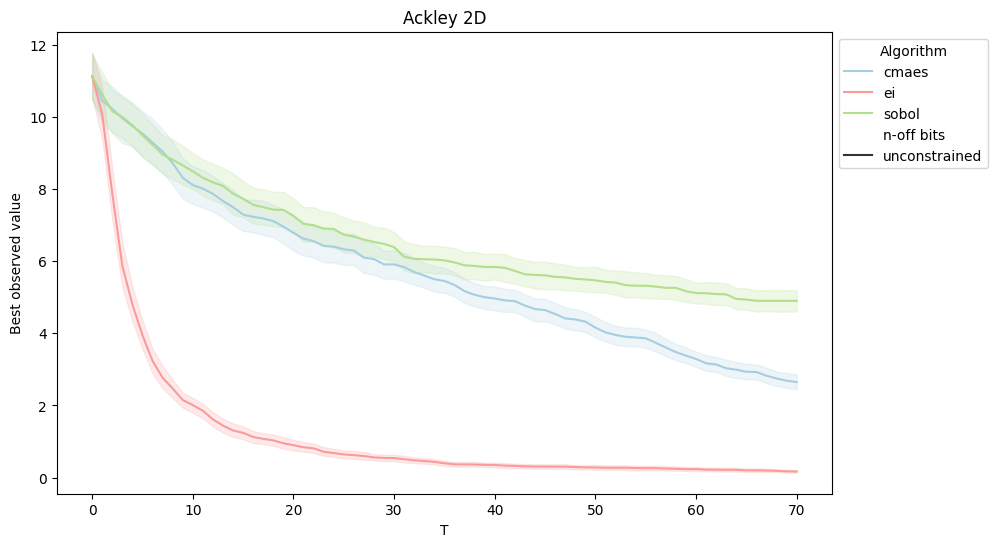

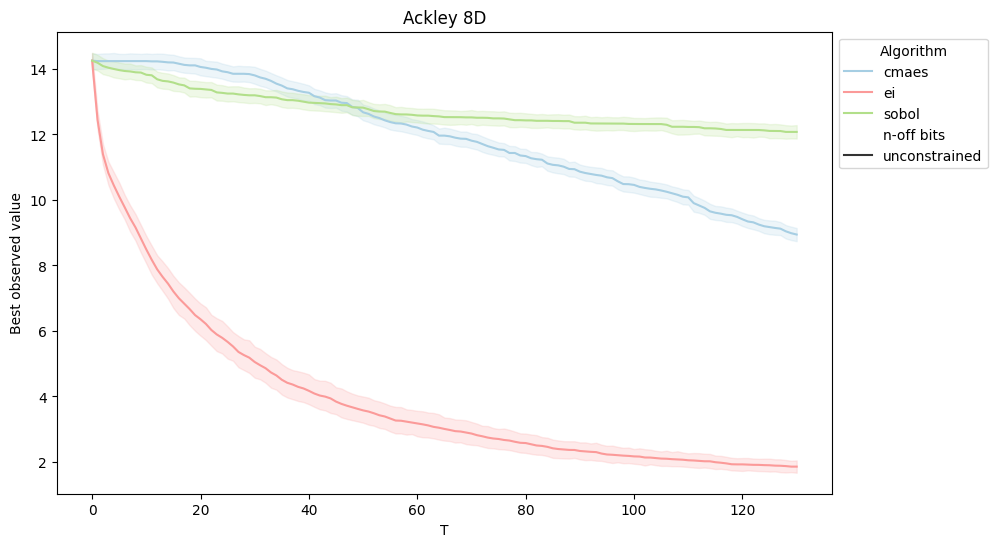

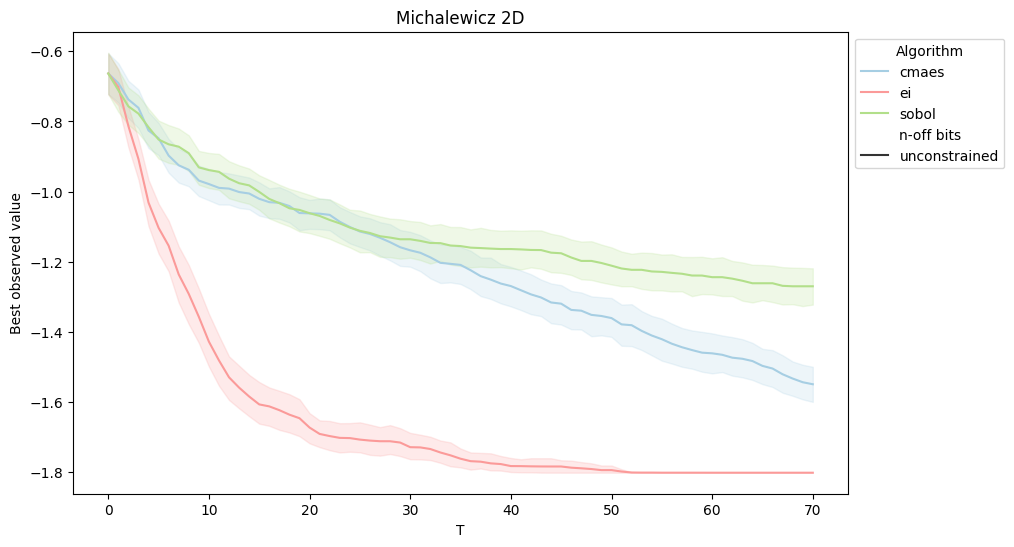

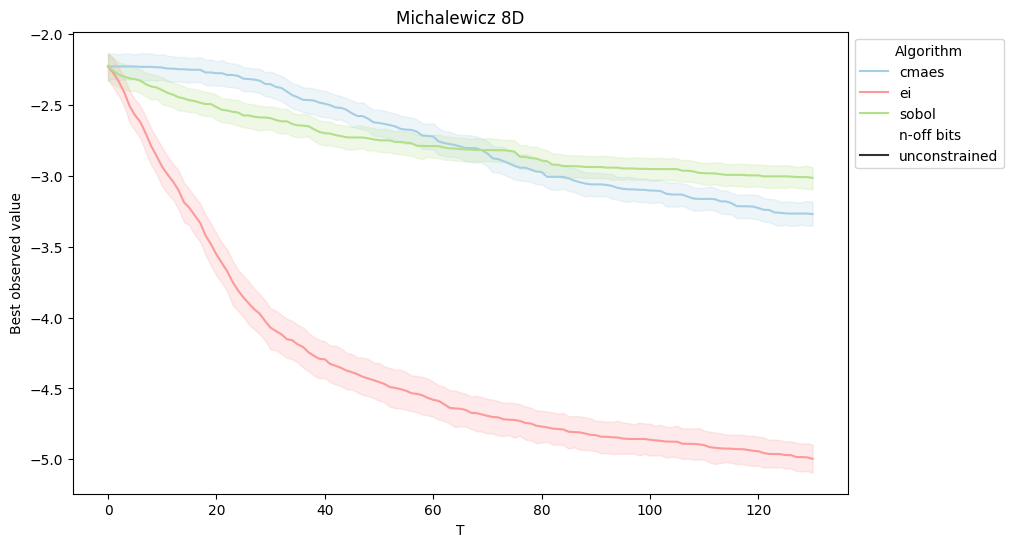

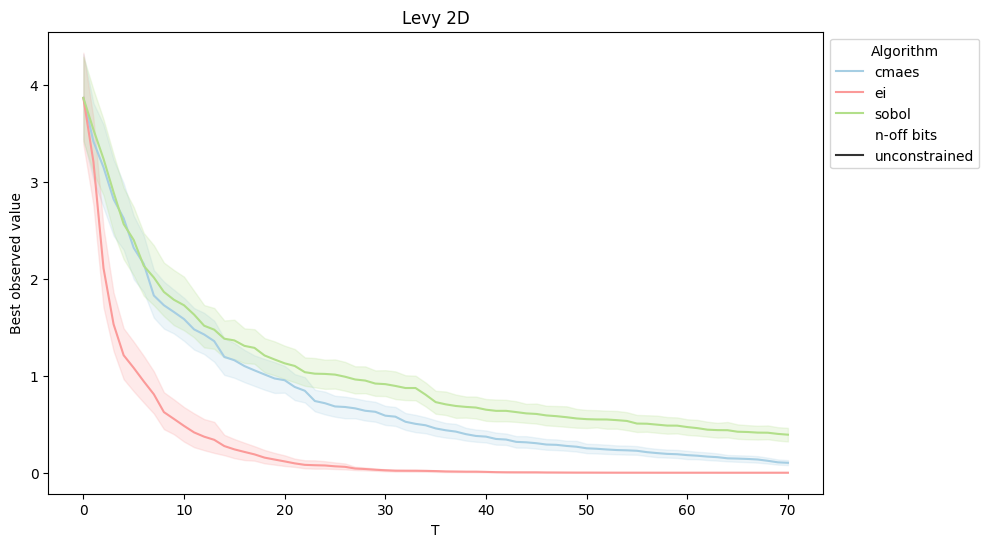

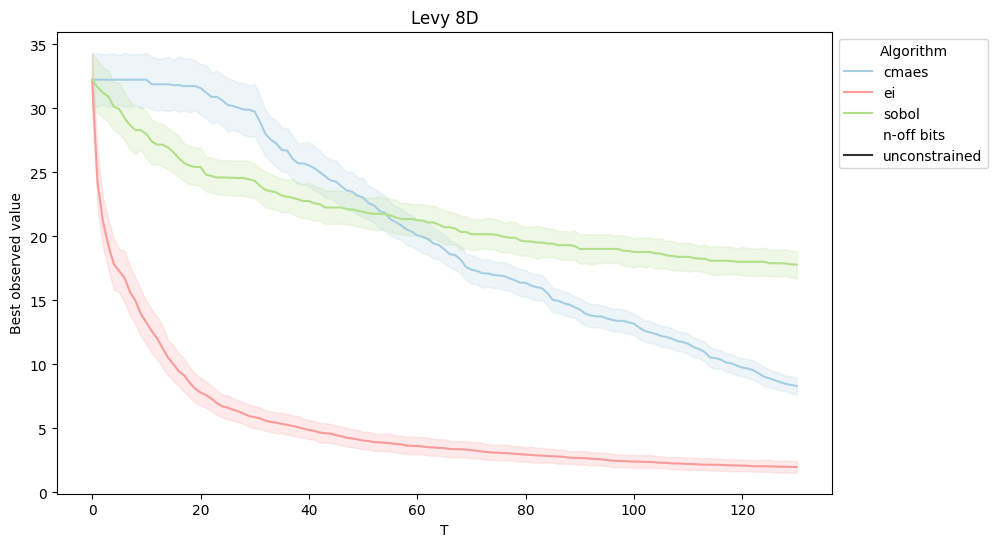

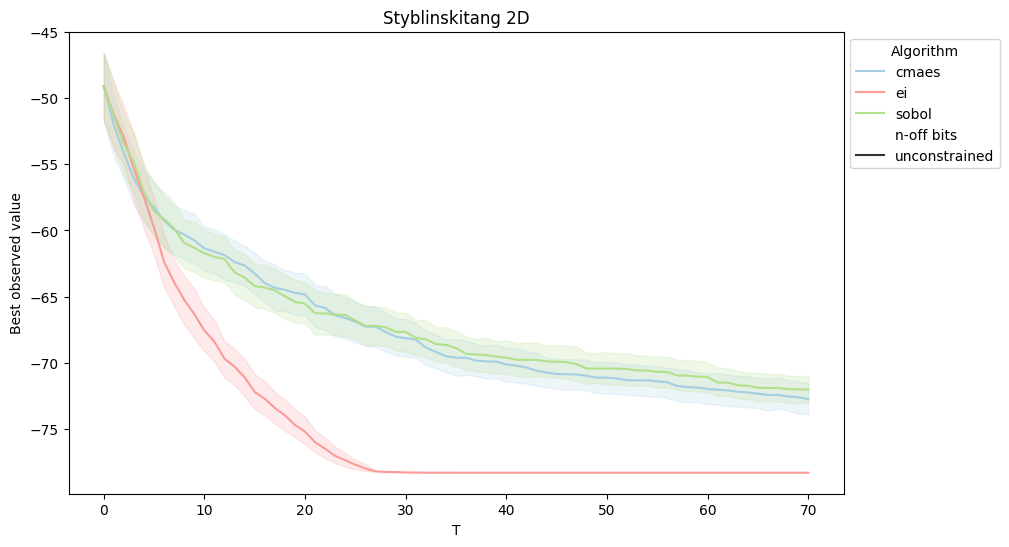

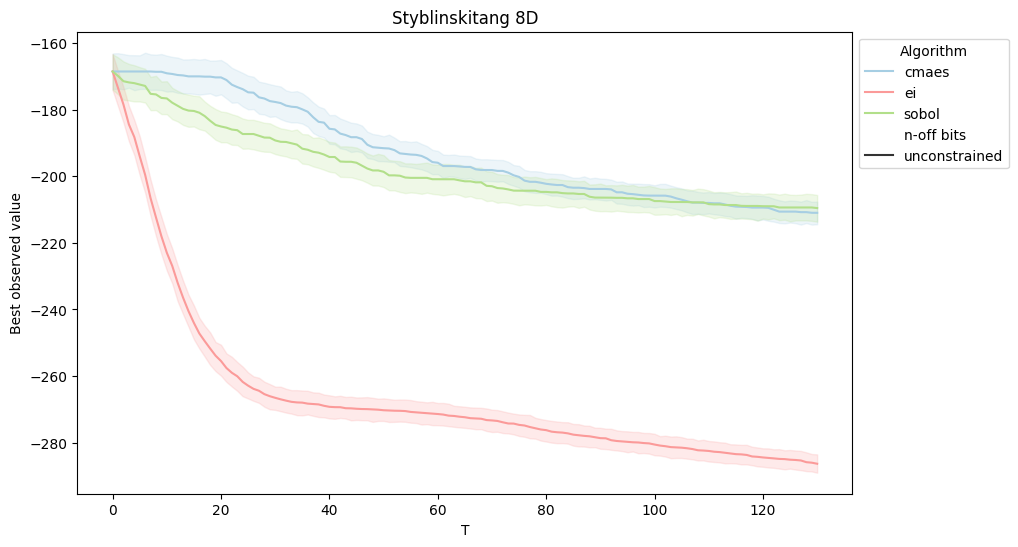

In [4]:

# Call the function for separate plots
plot_unconstrained_results(probs, dims, algos, separate_plots=True)

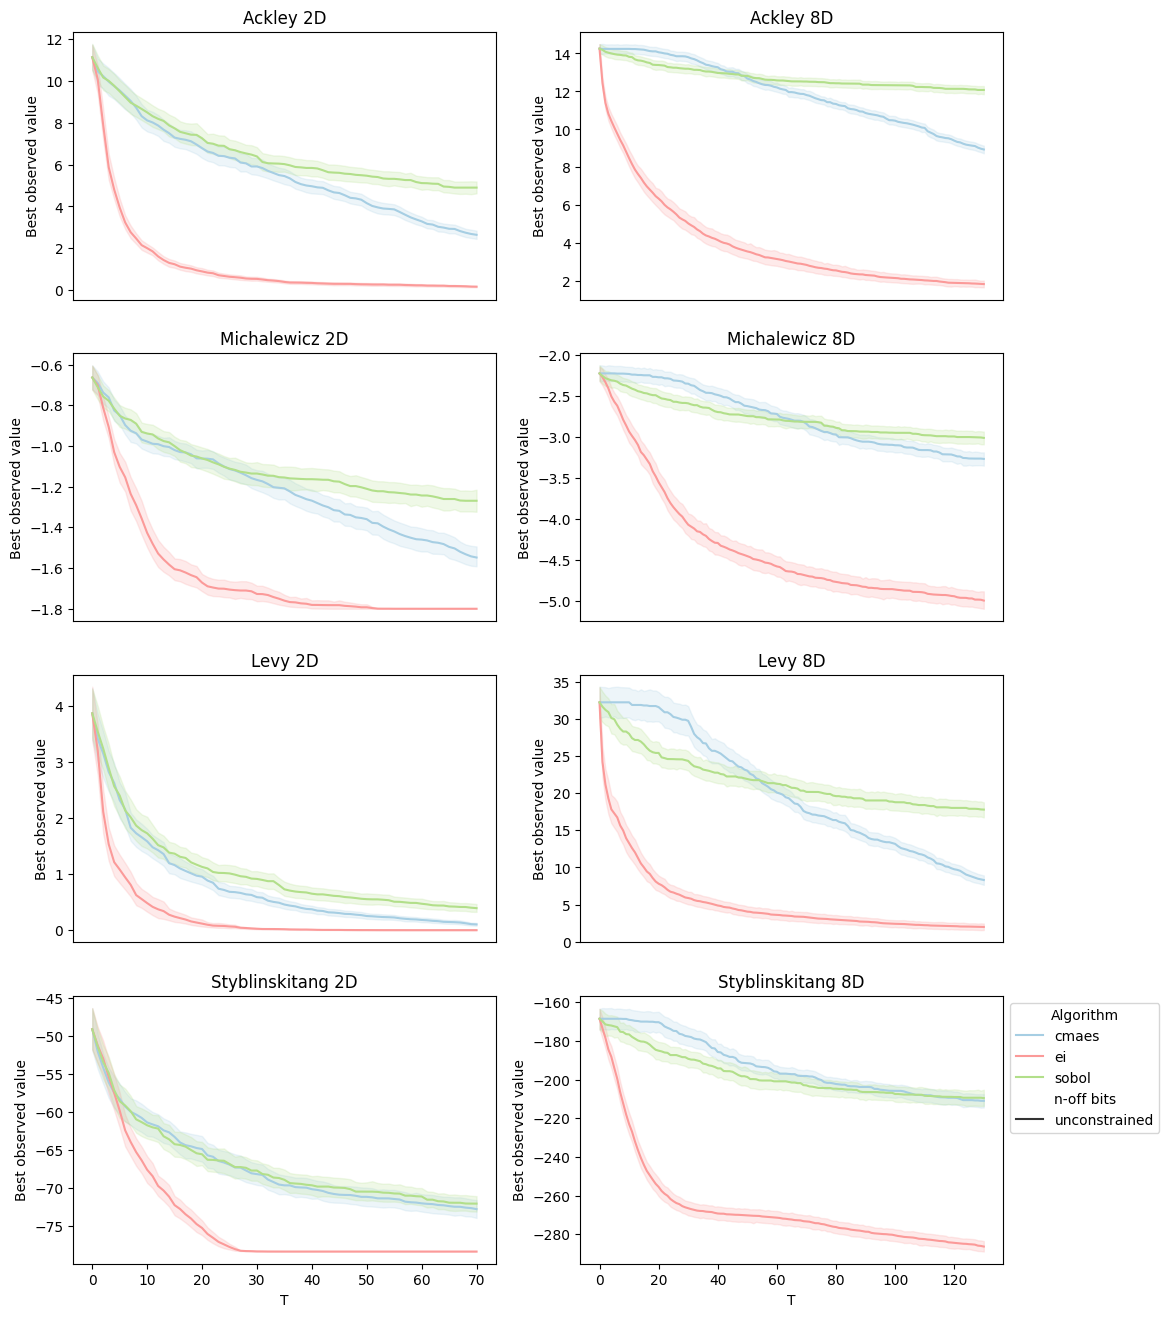

In [5]:
# Call the function for subplots (problems in rows, dimensions in columns)
plot_unconstrained_results(probs, dims, algos, separate_plots=False)

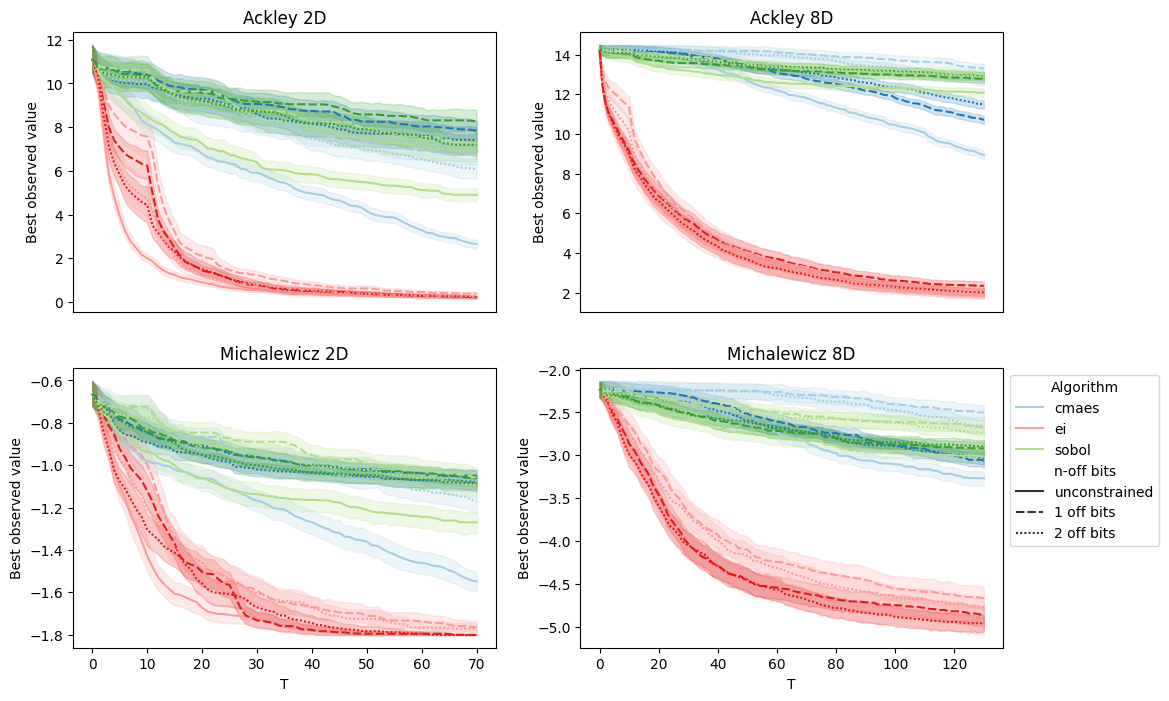

In [10]:
probs = [
    'ackley',
    'michalewicz',
#     'levy',
#     'styblinskitang'
]

plot_unconstrained_results(probs, dims, algos, separate_plots=False,
                           with_selected_delay=10,
                           save='ch3_convergence_ackmichal.pdf'
                           )

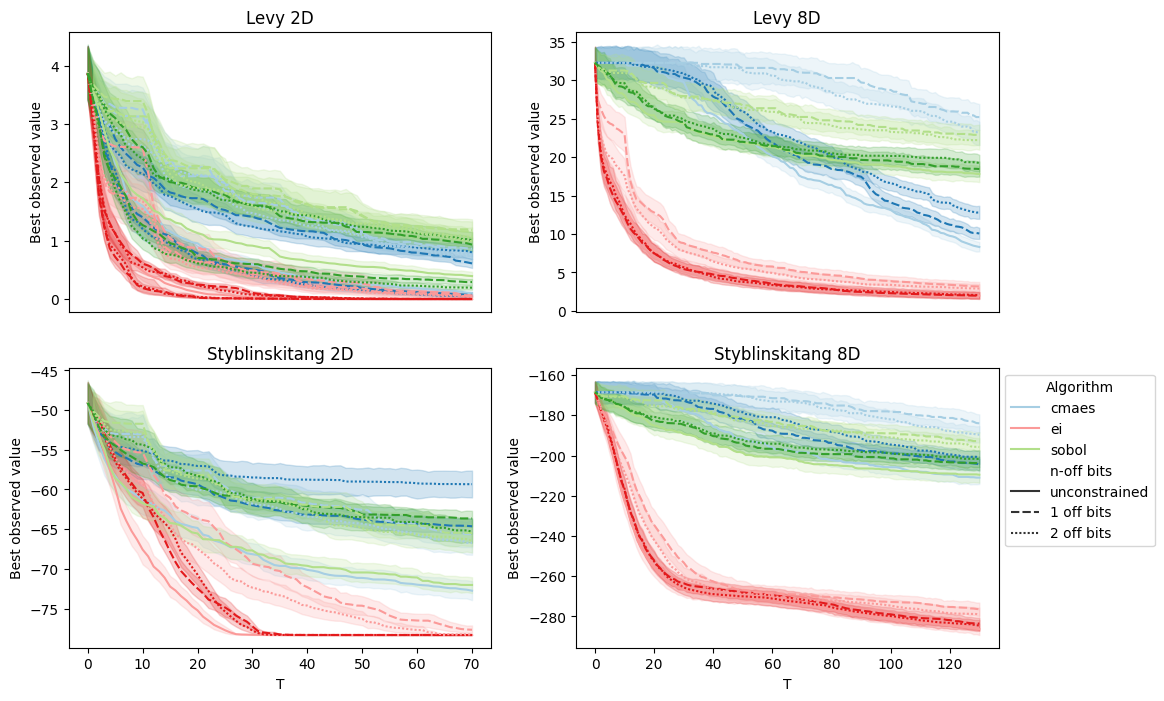

In [11]:
probs = [
    # 'ackley',
    # 'michalewicz',
        'levy',
        'styblinskitang'
]

plot_unconstrained_results(probs, dims, algos, separate_plots=False,
                           with_selected_delay=10,
                           save='ch3_convergence_levsty.pdf'
                           )